# **Car Insurance Subcribe Predition**
This is a dataset from one bank in the United States. Besides usual services, this bank also provides car
insurance services. The bank organizes regular campaigns to attract new clients. The bank has potential
customers’ data, and bank’s employees call them for advertising available car insurance options. We are
provided with general information about clients (age, job, etc.) as well as more specific information about the
current insurance sell campaign (communication, last contact day) and previous campaigns (attributes like
previous attempts, outcome).
You have data about 4000 customers who were contacted during the last campaign and for whom the results
of campaign (did the customer buy insurance or not) are known.


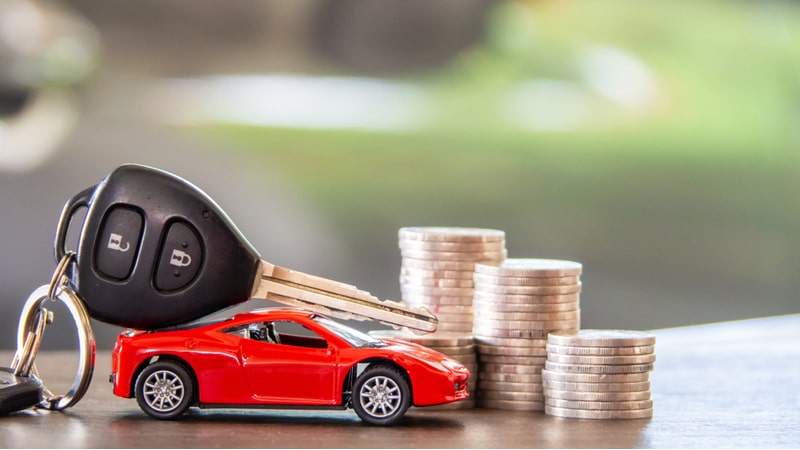

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

train = pd.read_csv("/kaggle/input/carinsurance/carInsurance_train.csv")
test = pd.read_csv("/kaggle/input/carinsurance/carInsurance_test.csv")

pd.set_option('display.max_columns', 200)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
print(train.shape,test.shape)

Combining data for data pre-processing



In [ ]:
train = train.append(test)
train.tail()

In [ ]:
train.describe()

In [ ]:
train.info()

1000 Nan values in CarInsurance in test data are for prediction.

In [ ]:
train.groupby('CarInsurance').count()["Id"]

In [ ]:
train.groupby('CarInsurance').count()["Id"].plot(kind="bar")

Calculated percent of missing values for features.

In [ ]:
Dic={}
for Column,Value in train.isnull().sum().items():
    if Value>0:
        Dic[Column]=Value
       
    
for Col,val in Dic.items():
    print(Col,"------",val,"------Percent of Missing values------",(val/4000)*100,"%")

Outcome feature has 94% missing values which is very high and cannot be replaced.

In [ ]:
train.drop(['Outcome'],axis =1, inplace = True)

In [ ]:
train.groupby('Communication').count()["Id"].plot(kind="bar")

In [ ]:
train['Education'].value_counts().plot.bar()

In [ ]:
train['Job'].value_counts().plot.bar()

All Categorical (except CarInsurance feature because 25% missing value comes fron test data) missing value replaced with mode(most frequent) value of that feature.

In [ ]:
 train['Job'].value_counts().index[0]   

In [ ]:
def impute_nan(df,variable):
    most_frequent_category=df[variable].value_counts().mode()[0]
    df[variable].fillna(most_frequent_category,inplace=True)

In [ ]:
for feature in ['Job','Education','Communication']:
    impute_nan(train,feature)

In [ ]:
train.isnull().sum()

Numerical encoding of Categorical features.

1. Ordinal variables (Martial,Education,LastCantactMonth) encoded with Numeric values
2. Job and Communication features encoded with respective count values.
3. CallEnd and CallStart features encoded with their diff of time of second.

In [ ]:
for feature in train.columns[:]:
    if train[feature].dtype == 'object':
        
        print(feature,":",len(train[feature].unique()),'labels')

In [ ]:
train['Education'].unique()

In [ ]:
train['Communication'].unique()

In [ ]:
train['Job'].unique()

In [ ]:
train['Marital'].unique()

In [ ]:
dic_month={'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
dic_edu={'primary':1,'secondary':2,'tertiary':3,694:2}
dic_comm={'telephone':0,'cellular':1,'tertiary':3,348:1}
dic_martial = {'single':1,'married':2,'divorced':3}
dic_job=train.Job.value_counts().to_dict()
dic_job[123]=1114   #Random number filled with mode category of Job feature.

In [ ]:
    dic_job

In [ ]:
train['LastContactMonth']=train['LastContactMonth'].map(dic_month)
train['Education']=train['Education'].map(dic_edu)
train['Communication']=train['Communication'].map(dic_comm)
train['Marital']=train['Marital'].map(dic_martial)
train['Job']=train['Job'].map(dic_job)

In [ ]:
train['Call']=(pd.to_datetime(train['CallEnd'])-pd.to_datetime(train['CallStart'])).astype('timedelta64[s]')

In [ ]:
train.drop(['CallEnd','CallStart'],axis =1, inplace = True)

Dividing dataset into previous ratio.

In [ ]:
test = train[4000:]
train = train[0:4000]

In [ ]:
test.isnull().sum()

In [ ]:
train.isnull().sum()

Correlation Matrix Plot for features Handling.

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(train.loc[:, train.columns != 'Id'].corr(), fignum=f.number)
plt.xticks(range(train.loc[:, train.columns != 'Id'].shape[1]), train.loc[:, train.columns != 'Id'].columns, fontsize=14, rotation=45)
plt.yticks(range(train.loc[:, train.columns != 'Id'].shape[1]), train.loc[:, train.columns != 'Id'].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
train_1=train.loc[:, train.columns != 'CarInsurance']
X_train = train_1.loc[:, train_1.columns != 'Id']
test_1=test.loc[:, test.columns != 'CarInsurance']
X_test = test_1.loc[:, test_1.columns != 'Id']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# transform data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Logistics and Random forest models are being used for Binary Classification. 

In [ ]:
        from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, train['CarInsurance'], test_size = 0.20, random_state = 101)

In [ ]:
#cross validation
from sklearn.model_selection  import cross_val_score as CVS
from sklearn.model_selection import cross_validate

def cross_val(model_name,model,X,y,cv):
    
    scores = CVS(model, X, y, cv=cv)
    print(f'{model_name} Scores:')
    for i in scores:
        print(round(i,2))
    print(f'Average {model_name} score: {round(scores.mean(),4)}')
  

Applying RandomForestClassifier

In [ ]:

## Apply RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

#cross validation
RF_report = pd.DataFrame(cross_validate(rf_model, X_train, np.array(train['CarInsurance']), scoring=['accuracy','precision', 'recall','f1']))
#getting required score methods
RF_report = RF_report.iloc[:,2:]
#naming the index
RF_report.index = ['Valid1','Valid2','Valid3','Valid4','Valid5']


#final result collection
model_1 = []

#Classification report
print("Clasification report:\n")
print(RF_report,"\n\n")
print("Mean Scores:\n")
for score in RF_report.columns:
    print(f"\t{score}: {round(RF_report[score].mean(),4)}")
    model_1.append(round(RF_report[score].mean(),4))

In [ ]:
rf_model.fit(Xtrain,ytrain)
ytrain_pred = rf_model.predict_proba(Xtrain)
print('RF train roc-auc: {}'.format(roc_auc_score(ytrain, ytrain_pred[:,1])))
ytest_pred = rf_model.predict_proba(Xtest)
print('RF test roc-auc: {}'.format(roc_auc_score(ytest, ytest_pred[:,1])))

Applying LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_classifier=LogisticRegression()


#cross validation
LR_report = pd.DataFrame(cross_validate(log_classifier, X_train, np.array(train['CarInsurance']), scoring=['accuracy','precision', 'recall','f1']))
#getting required score methods
LR_report = LR_report.iloc[:,2:]
#naming the index
LR_report.index = ['Valid1','Valid2','Valid3','Valid4','Valid5']


#final result collection
model_2 = []

#Classification report
print("Clasification report:\n")
print(LR_report,"\n\n")
print("Mean Scores:\n")
for score in LR_report.columns:
    print(f"\t{score}: {round(LR_report[score].mean(),4)}")
    model_2.append(round(LR_report[score].mean(),4))


In [ ]:
log_classifier.fit(Xtrain,ytrain)
ytrain_pred_2 = log_classifier.predict_proba(Xtrain)
print('Logistic train roc-auc: {}'.format(roc_auc_score(ytrain, ytrain_pred_2[:,1])))
ytest_pred_2 = log_classifier.predict_proba(Xtest)
print('Logistic test roc-auc: {}'.format(roc_auc_score(ytest, ytest_pred_2[:,1])))

Comparing Both models Perfomance

In [ ]:
Models = pd.DataFrame({
    'Logistic Regression': np.array(model_2),
    'Random Forest': np.array(model_1)})
Models.index = ['accuracy','precision', 'recall','f1']
Models

Identifying Important features for Class variable using Models coef.

Logistics Regression coef for **Feature** **Importance**

In [ ]:
# get importance
importance = log_classifier.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
	  print('Feature: %0d, Score: %.5f' % (i,v))
 

# plot feature importance



plt.bar([x for x in range(len(importance))], importance)

plt.show()


Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

Random Forest Classification coef for **Feature** **Importance**

In [ ]:
# get importance
importance = rf_model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	  print('Feature: %0d, Score: %.5f' % (i,v))
 

# plot feature importance



plt.bar([x for x in range(len(importance))], importance)

plt.show()


Random forest feature selection.
The results suggest perhaps **0,5,9,10 and 14** of the 14 features as being important to prediction

**Ensembling the models performance**

In [ ]:
pred=[]
for model in [rf_model,log_classifier]:
    pred.append(pd.Series(model.predict_proba(Xtest)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(ytest,final_prediction)))

Prediction of four model for each test rows and average of four prediction taken for ensembled model.

In [ ]:
pd.concat(pred,axis=1) 

Threshold value is very important for binary classification. As a Default, 0.5 is threshold for 0,1 classification but it can be different for Datasets for better performance.

In [ ]:
#### Calculate the ROc Curve


fpr, tpr, thresholds = roc_curve(ytest, final_prediction)
thresholds

Based on high accuracy,Threshold value is calculated for the binary classification.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(ytest, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head(10)

Plot of RoC Curve

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
plot_roc_curve(fpr,tpr)

Confusion Matrix and Classification Report for Best threshold value 0.405576

In [ ]:
new_pred = np.where(final_prediction>0.405576,1,0)

confusion_matrix(ytest, new_pred)

In [ ]:

print(classification_report(ytest, new_pred))

In [ ]:
real_pred=[]
for model in [rf_model,log_classifier]:
    real_pred.append(pd.Series(model.predict_proba(np.array(X_test))[:,1]))
real_final_prediction=pd.concat(real_pred,axis=1).mean(axis=1)


In [ ]:
real_final_prediction= np.where(real_final_prediction>0.447406,1,0)
df = pd.DataFrame(data=real_final_prediction.flatten())
df.head(10)